In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [35]:
# Data Loading
data = pd.read_csv("term-deposit-marketing-2020.csv")
print("Data Loaded Successfully")

Data Loaded Successfully


In [45]:
# Data Preprocessing

# Generating summary statistics
summary_statistics = data.describe()
print("Summary Statistics:")
print(summary_statistics)

# Generating unique values for categorical data
unique_values = data.select_dtypes(include=['object']).nunique()
print("\nUnique Values in Categorical Columns:")
print(unique_values)

# Generating correlation matrix
correlation_matrix = data.corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)

Summary Statistics:
                age        balance           day      duration      campaign
count  40000.000000   40000.000000  40000.000000  40000.000000  40000.000000
mean      40.544600    1274.277550     16.017225    254.824300      2.882175
std        9.641776    2903.769716      8.278127    259.366498      3.239051
min       19.000000   -8019.000000      1.000000      0.000000      1.000000
25%       33.000000      54.000000      8.000000    100.000000      1.000000
50%       39.000000     407.000000     17.000000    175.000000      2.000000
75%       48.000000    1319.000000     21.000000    313.000000      3.000000
max       95.000000  102127.000000     31.000000   4918.000000     63.000000

Unique Values in Categorical Columns:
job          12
marital       3
education     4
default       2
housing       2
loan          2
contact       3
month        11
y             2
dtype: int64

Correlation Matrix:
               age   balance       day  duration  campaign
age       1

C:\Users\aldhu\AppData\Local\Temp\ipykernel_11032\1584245355.py:14: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


In [46]:
# Data Quality Checks

# Checking for missing values in each column
missing_values = data.isnull().sum()
print("Missing Values in Each Column:")
print(missing_values)

# Checking for the total number of duplicate rows
duplicate_rows = data.duplicated().sum()
print("\nTotal Number of Duplicate Rows:")
print(duplicate_rows)

# Displaying data types of each column
data_types = data.dtypes
print("\nData Types of Each Column:")
print(data_types)

Missing Values in Each Column:
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

Total Number of Duplicate Rows:
0

Data Types of Each Column:
age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
y            object
dtype: object


In [38]:
# Count the occurrences of each class
class_counts = data['y'].value_counts()

# Identify the minority and majority classes
minority_class = class_counts.idxmin()
majority_class = class_counts.idxmax()

print("Minority Class:", minority_class)
print("Majority Class:", majority_class)

Minority Class: yes
Majority Class: no


In [39]:
# Count the occurrences of each class
class_counts = data['y'].value_counts()

# Determine the minority and majority classes based on counts
if class_counts[0] < class_counts[1]:
    minority_class_label = 0
    majority_class_label = 1
else:
    minority_class_label = 1
    majority_class_label = 0

print("Minority Class Label:", minority_class_label)
print("Majority Class Label:", majority_class_label)

Minority Class Label: 1
Majority Class Label: 0


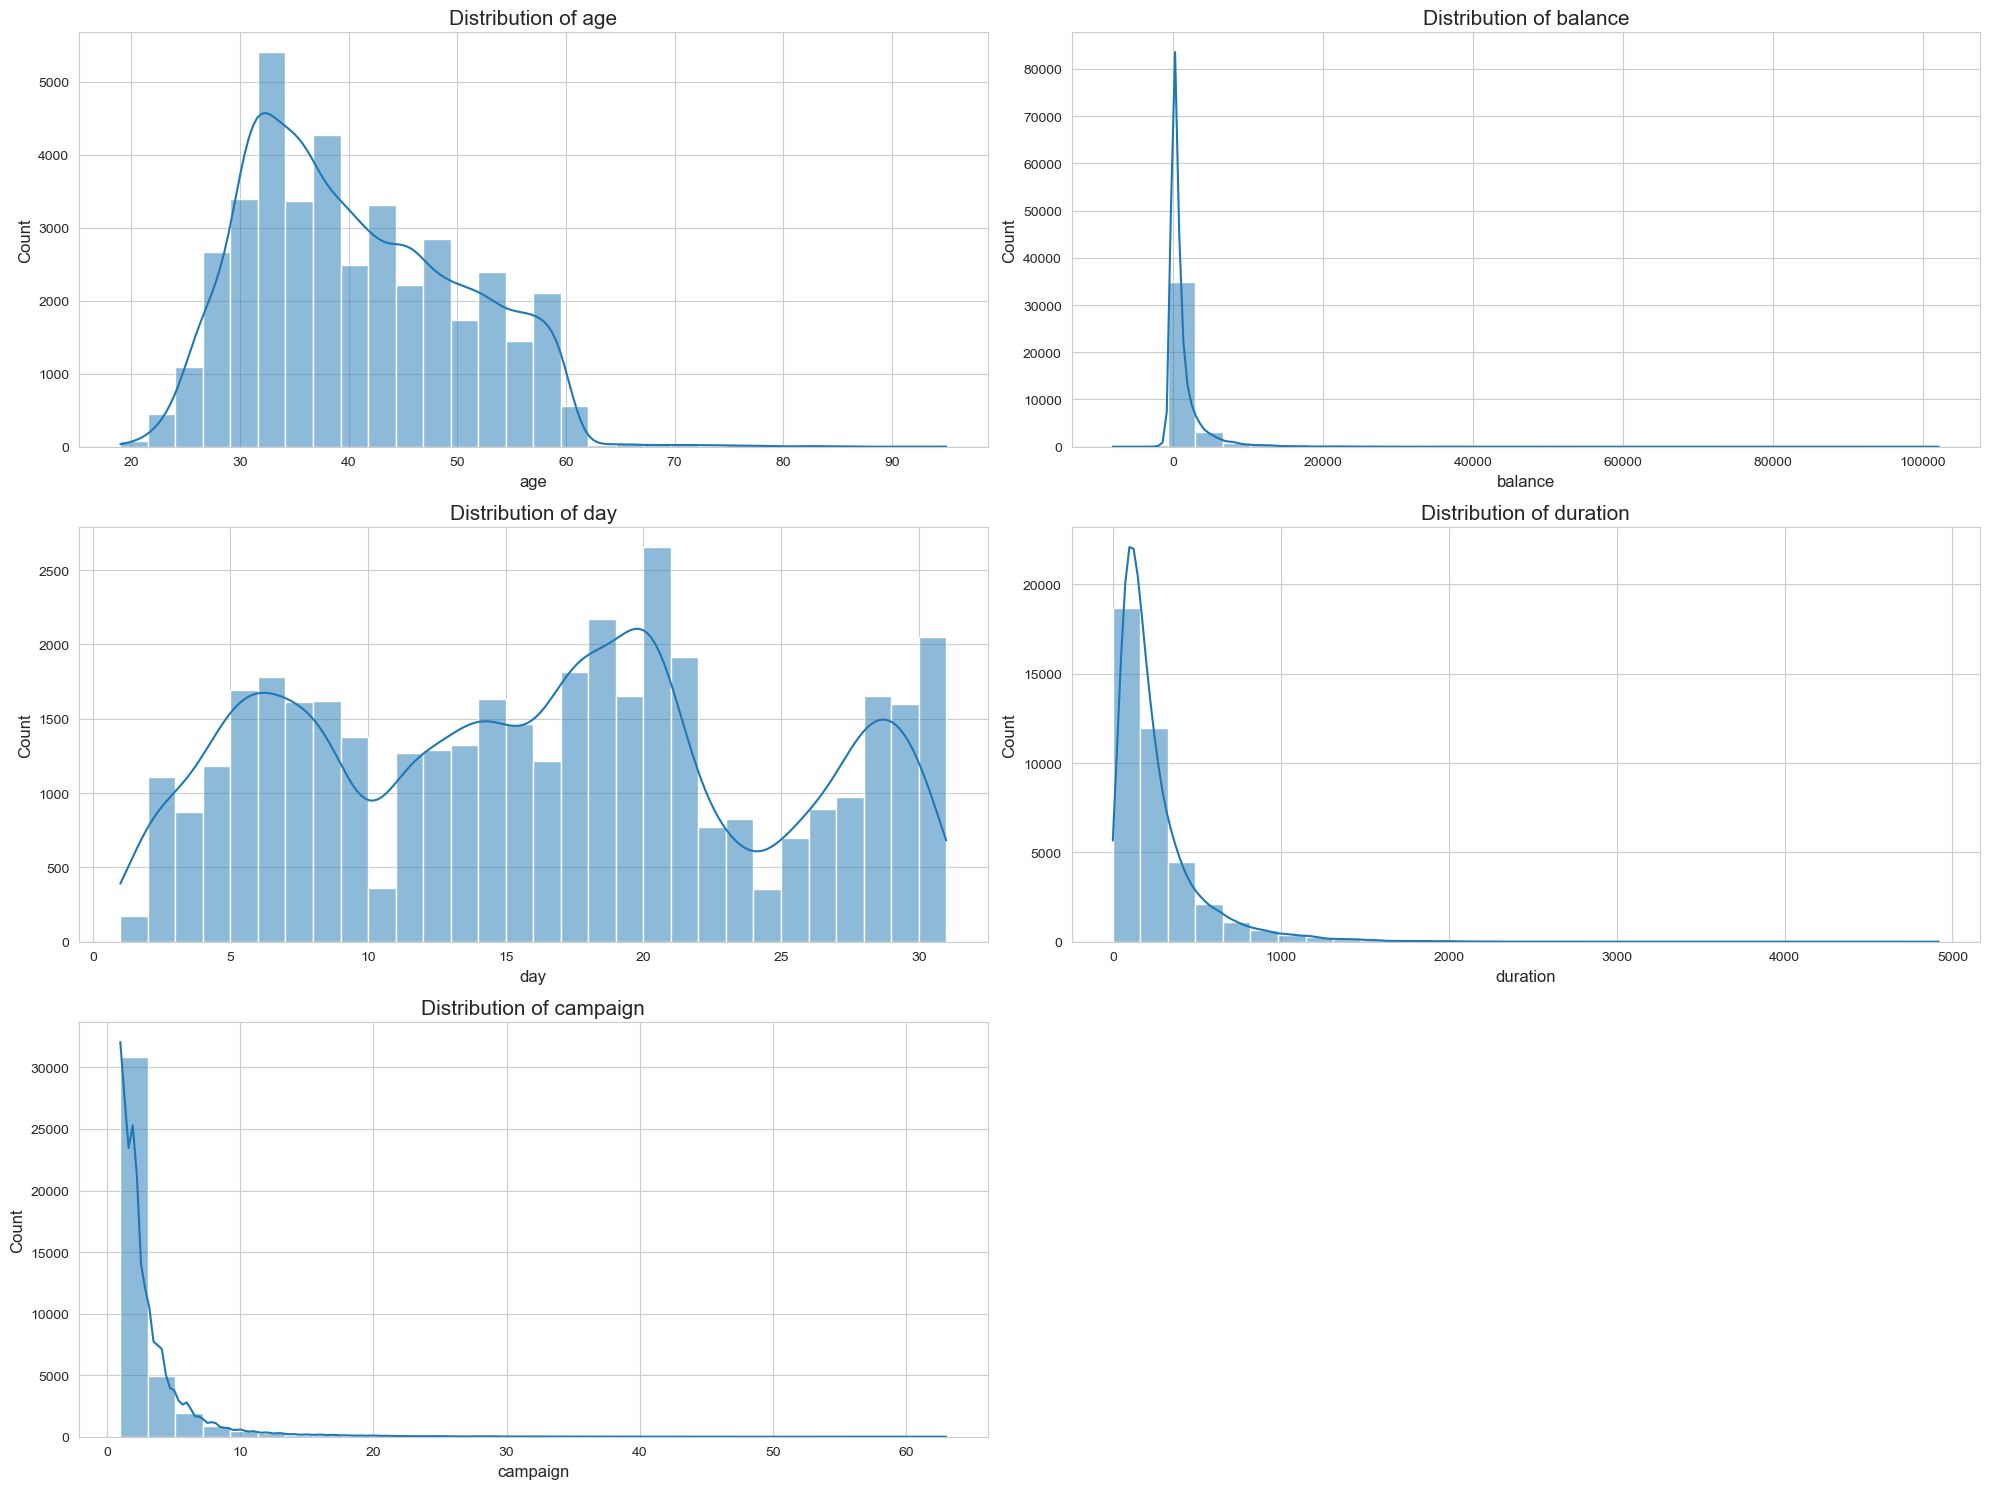

In [40]:
# Data Visualization
# Creating histograms for numerical columns
sns.set_style("whitegrid")
numerical_cols = ['age', 'balance', 'day', 'duration', 'campaign']
plt.figure(figsize=(20, 15))
for index, col in enumerate(numerical_cols):
    plt.subplot(3, 2, index + 1)
    sns.histplot(data[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}', fontsize=15)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\aldhu\AppData\Local\Temp\ipykernel_11032\2969362137.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')


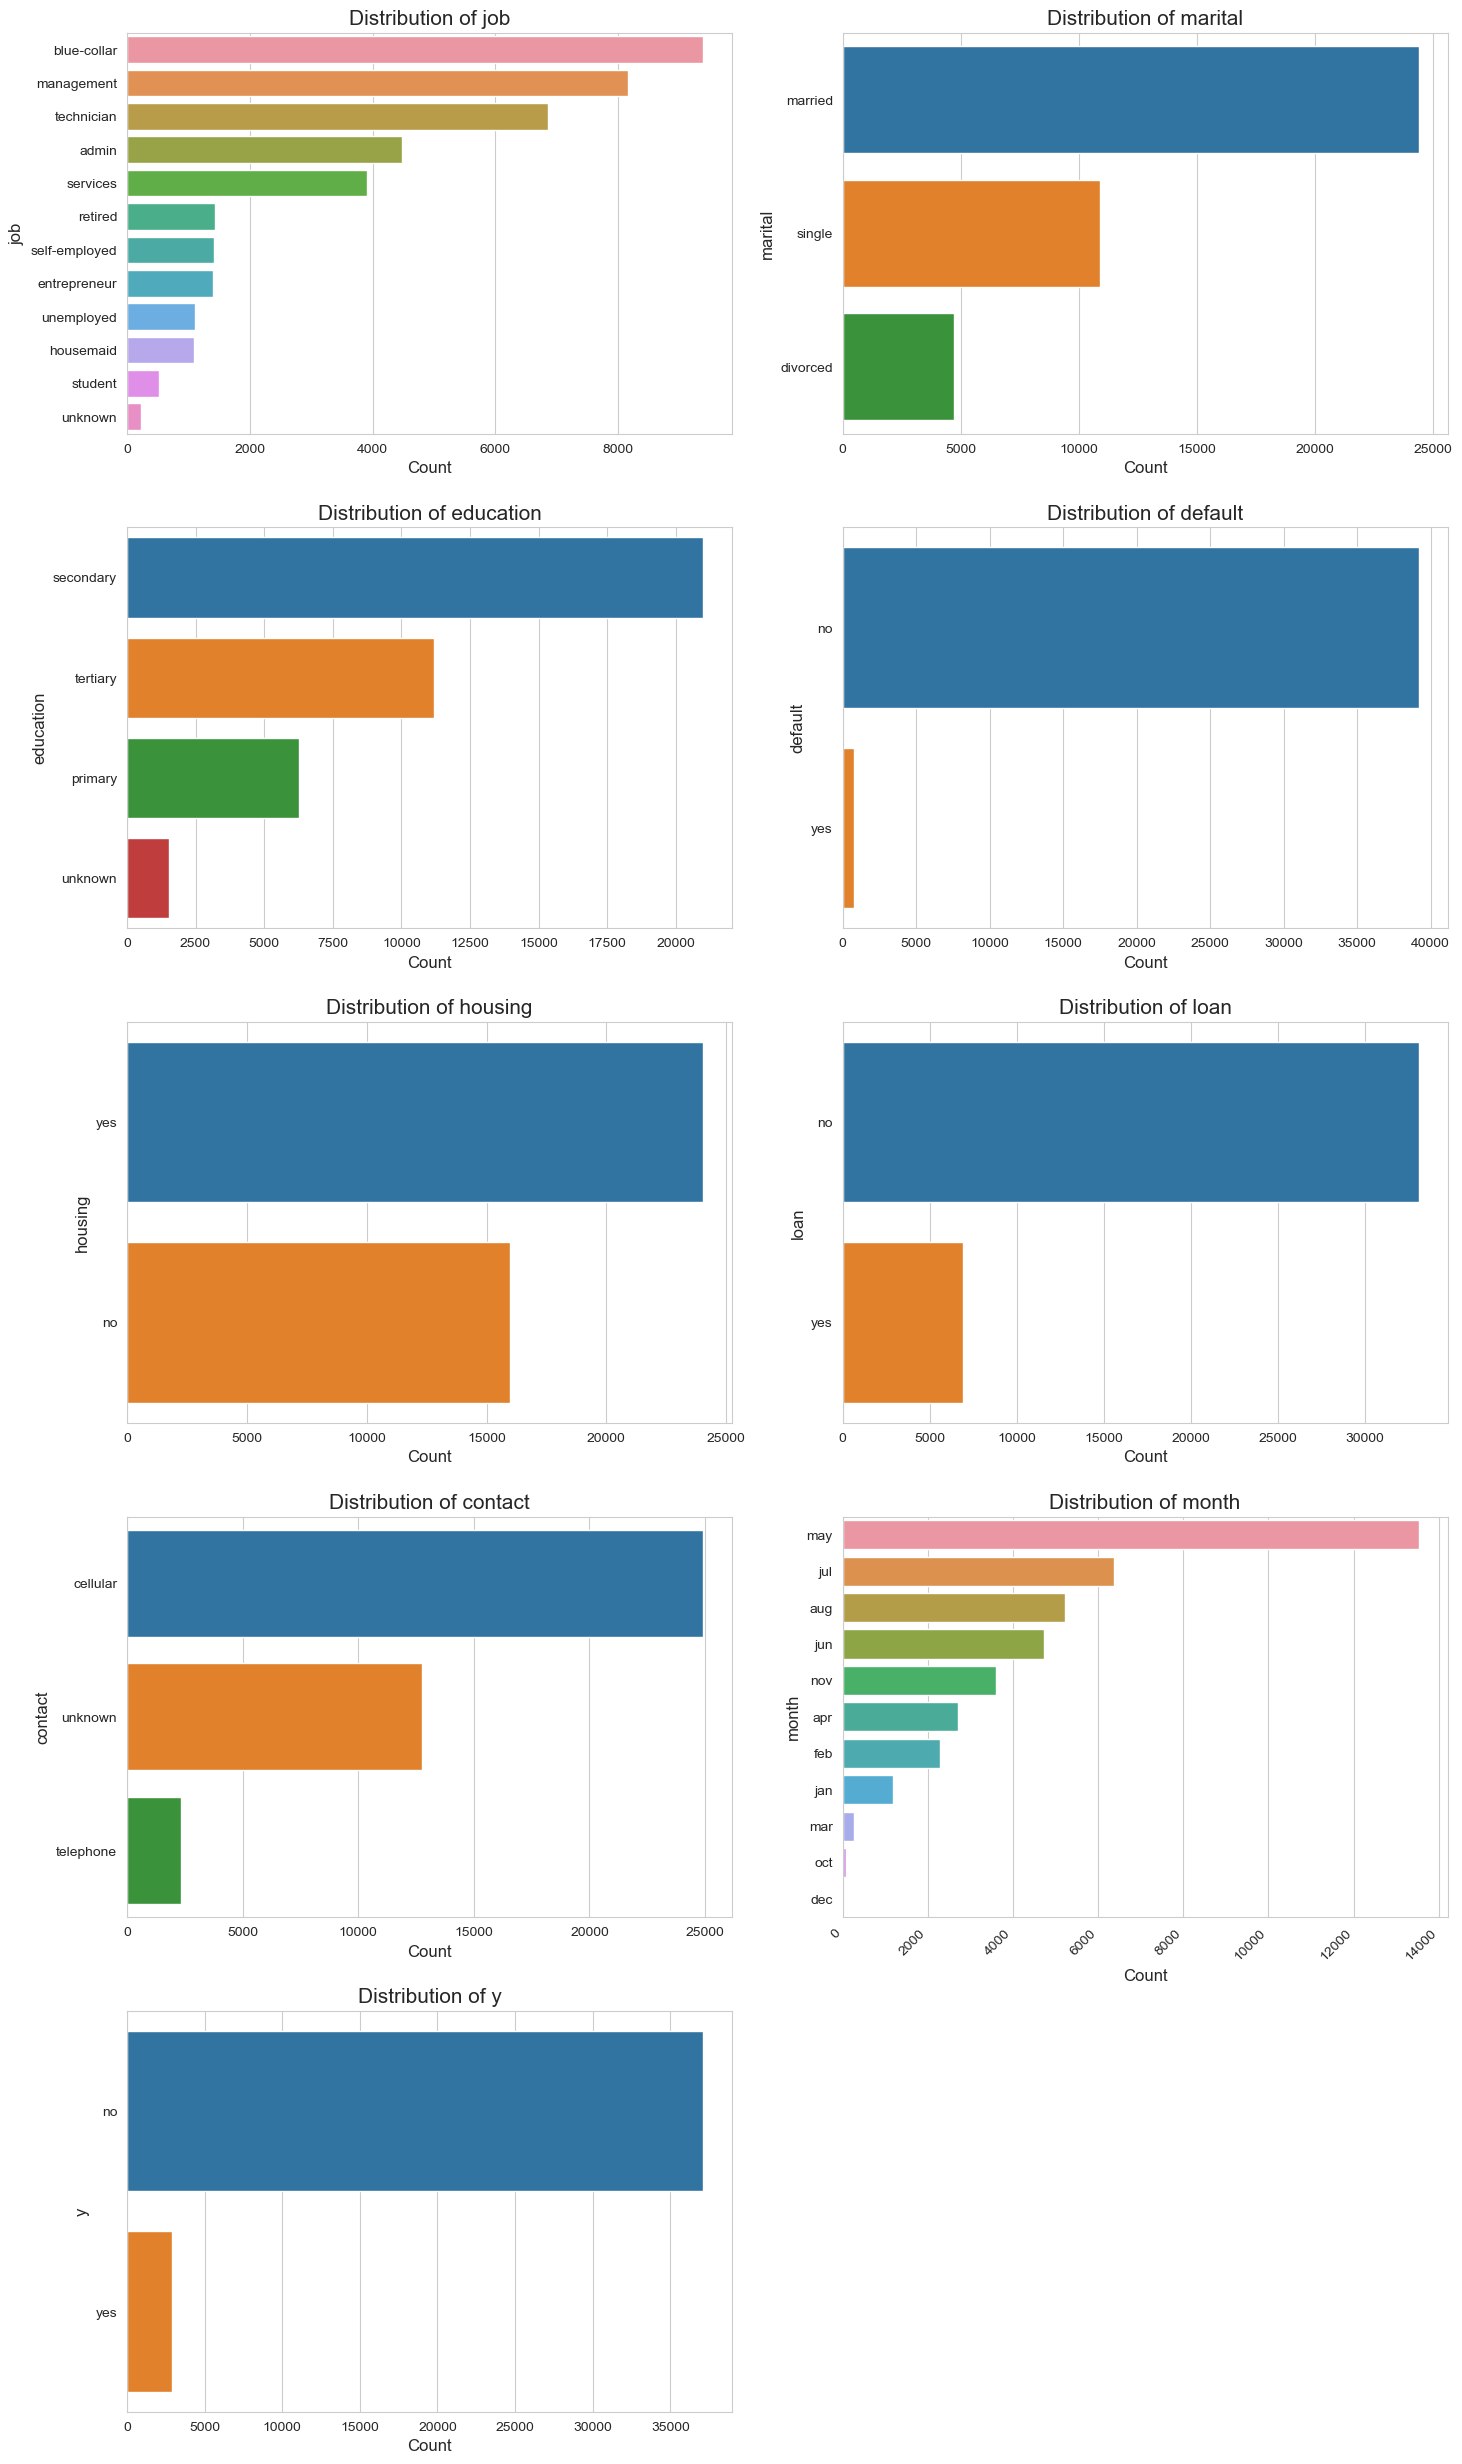

In [41]:
# Creating bar charts for categorical columns
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'y']
num_columns = 2
num_rows = (len(categorical_cols) + num_columns - 1) // num_columns
plt.figure(figsize=(15, num_rows * 5))
for index, col in enumerate(categorical_cols):
    plt.subplot(num_rows, num_columns, index + 1)
    chart = sns.countplot(y=data[col], order=data[col].value_counts().index)
    plt.title(f'Distribution of {col}', fontsize=15)
    plt.xlabel('Count', fontsize=12)
    plt.ylabel(col, fontsize=12)
    if col == 'month':
        chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.tight_layout(pad=2)
plt.show()

In [43]:
# Encoding Categorical Data
# Using One-Hot Encoding and Label Encoding for categorical features
encoded_data = data.copy()
onehot_encoder = OneHotEncoder(sparse=False, drop='first')
label_encoder = LabelEncoder()
onehot_cols = ['job', 'marital', 'education', 'contact', 'month']
label_cols = ['default', 'housing', 'loan', 'y']
for col in onehot_cols:
    encoded_col = onehot_encoder.fit_transform(encoded_data[[col]])
    encoded_col_df = pd.DataFrame(encoded_col, columns=[f"{col}_{cat}" for cat in onehot_encoder.categories_[0][1:]])
    encoded_data = pd.concat([encoded_data.drop(col, axis=1), encoded_col_df], axis=1)
for col in label_cols:
    encoded_data[col] = label_encoder.fit_transform(encoded_data[col])

C:\Users\aldhu\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\aldhu\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\aldhu\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\aldhu\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. 

In [11]:
# Train-Test Split
X = encoded_data.drop('y', axis=1)
y = encoded_data['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5-Fold Cross-Validation 
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"{model_name} Model - Average Accuracy: {np.mean(cv_scores):.4f}")

Decision Tree Model - Average Accuracy: 0.9117
Random Forest Model - Average Accuracy: 0.9351
XGBoost Model - Average Accuracy: 0.9354


In [8]:
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Print the classification report for precision, recall, and F1-score
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))

    # Calculate and print the ROC-AUC score
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"ROC-AUC Score for {model_name}: {roc_auc:.4f}")
    print("=" * 50)

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      7424
           1       0.40      0.44      0.42       576

    accuracy                           0.91      8000
   macro avg       0.68      0.70      0.69      8000
weighted avg       0.92      0.91      0.91      8000

ROC-AUC Score for Decision Tree: 0.6959
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      7424
           1       0.61      0.33      0.43       576

    accuracy                           0.94      8000
   macro avg       0.78      0.66      0.70      8000
weighted avg       0.93      0.94      0.93      8000

ROC-AUC Score for Random Forest: 0.6576
Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      7424
           1       0.59      0.44      0

In [13]:
# Apply SMOTE to oversample the minority class in the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Reinitialize the models for training
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Train the models and evaluate performance on the test set
for model_name, model in models.items():
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test)

    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"ROC-AUC Score for {model_name}: {roc_auc:.4f}")

    f1 = f1_score(y_test, y_pred)
    print(f"F1 Score for {model_name}: {f1:.4f}")
    print("=" * 50)

ROC-AUC Score for Decision Tree: 0.7092
F1 Score for Decision Tree: 0.4426
ROC-AUC Score for Random Forest: 0.6728
F1 Score for Random Forest: 0.4531
ROC-AUC Score for XGBoost: 0.7200
F1 Score for XGBoost: 0.5143


In [14]:
# Reinitialize the models for cross-validation on the balanced dataset
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Perform 5-fold cross-validation and print the average accuracy for each model
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_train_smote, y_train_smote, cv=5)
    print(f"{model_name} Model - Average Accuracy after SMOTE (5-Fold CV): {np.mean(cv_scores):.4f}")

Decision Tree Model - Average Accuracy after SMOTE (5-Fold CV): 0.9425
Random Forest Model - Average Accuracy after SMOTE (5-Fold CV): 0.9545
XGBoost Model - Average Accuracy after SMOTE (5-Fold CV): 0.9490


In [16]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Create a dictionary mapping class labels to their weights
weights = {i: class_weights[i] for i in range(len(class_weights))}


# Initialize models with class weights
models = {
    'Decision Tree': DecisionTreeClassifier(class_weight=weights),
    'Random Forest': RandomForestClassifier(class_weight=weights),
    'XGBoost': XGBClassifier(scale_pos_weight=weights[1], use_label_encoder=False, eval_metric='logloss')  # XGBoost uses scale_pos_weight for binary classification
}

# Train and evaluate the models
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate and print ROC AUC score
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"ROC-AUC Score for {model_name}: {roc_auc:.4f}")

    # Calculate and print F1 score
    f1 = f1_score(y_test, y_pred)
    print(f"F1 Score for {model_name}: {f1:.4f}")
    print("=" * 50)

ROC-AUC Score for Decision Tree: 0.6815
F1 Score for Decision Tree: 0.4172
ROC-AUC Score for Random Forest: 0.6129
F1 Score for Random Forest: 0.3416
ROC-AUC Score for XGBoost: 0.8385
F1 Score for XGBoost: 0.5726


In [24]:
# Triple the weight of the minority class
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

minority_class = 1
weights = {i: (class_weights[i] * 3 if i == minority_class else class_weights[i]) for i in range(len(class_weights))}

models = {
    'Decision Tree': DecisionTreeClassifier(class_weight=weights),
    'Random Forest': RandomForestClassifier(class_weight=weights),
    'XGBoost': XGBClassifier(scale_pos_weight=weights[1], use_label_encoder=False, eval_metric='logloss')
}

# Train and evaluate the models
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"ROC-AUC Score for {model_name}: {roc_auc:.4f}")

    f1 = f1_score(y_test, y_pred)
    print(f"F1 Score for {model_name}: {f1:.4f}")
    print("=" * 50)

ROC-AUC Score for Decision Tree: 0.6815
F1 Score for Decision Tree: 0.4138
ROC-AUC Score for Random Forest: 0.6038
F1 Score for Random Forest: 0.3243
ROC-AUC Score for XGBoost: 0.8660
F1 Score for XGBoost: 0.5399


In [29]:
# Define hyperparameter grids
dt_params = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3]
}

rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
}

xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}

# Initialize models with class weights
models = {
    'Decision Tree': DecisionTreeClassifier(class_weight=weights),
    'Random Forest': RandomForestClassifier(class_weight=weights),
    'XGBoost': XGBClassifier(scale_pos_weight=weights[1], use_label_encoder=False, eval_metric='logloss')
}

# Perform hyperparameter tuning
for model_name, model in models.items():
    if model_name == 'Decision Tree':
        search = GridSearchCV(model, dt_params, cv=5, scoring='roc_auc')
    elif model_name == 'Random Forest':
        search = GridSearchCV(model, rf_params, cv=5, scoring='roc_auc')
    elif model_name == 'XGBoost':
        search = RandomizedSearchCV(model, xgb_params, cv=5, scoring='roc_auc', n_iter=10)

    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)

    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"Best ROC-AUC Score for {model_name}: {roc_auc:.4f}")

    f1 = f1_score(y_test, y_pred)
    print(f"Best F1 Score for {model_name}: {f1:.4f}")
    print("=" * 50)

Best ROC-AUC Score for Decision Tree: 0.8606
Best F1 Score for Decision Tree: 0.3905
Best ROC-AUC Score for Random Forest: 0.8013
Best F1 Score for Random Forest: 0.5631
Best ROC-AUC Score for XGBoost: 0.8934
Best F1 Score for XGBoost: 0.4731


In [33]:
# Triple the weight of the minority class
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
minority_class = 1  
weights = {i: (class_weights[i] * 3 if i == minority_class else class_weights[i]) for i in range(len(class_weights))}

dt_params = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3]
}
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
}
xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}

# Initialize models with class weights
models = {
    'Decision Tree': DecisionTreeClassifier(class_weight=weights),
    'Random Forest': RandomForestClassifier(class_weight=weights),
    'XGBoost': XGBClassifier(scale_pos_weight=weights[1], use_label_encoder=False, eval_metric='logloss')
}

# Perform hyperparameter tuning and evaluation
for model_name, model in models.items():
    if model_name == 'Decision Tree':
        search = GridSearchCV(model, dt_params, cv=5, scoring='accuracy')
    elif model_name == 'Random Forest':
        search = GridSearchCV(model, rf_params, cv=5, scoring='accuracy')
    elif model_name == 'XGBoost':
        search = RandomizedSearchCV(model, xgb_params, cv=5, scoring='accuracy', n_iter=10)

    search.fit(X_train, y_train)
    best_model = search.best_estimator_

    # Make predictions on the test set
    y_pred = best_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Model: {model_name}")
    print(f"Best Accuracy: {accuracy:.4f}")
    print(f"Best ROC-AUC Score: {roc_auc:.4f}")
    print(f"Best F1 Score: {f1:.4f}")
    print("=" * 50)

Model: Decision Tree
Best Accuracy: 0.9197
Best ROC-AUC Score: 0.6933
Best F1 Score: 0.4349
Model: Random Forest
Best Accuracy: 0.9330
Best ROC-AUC Score: 0.5948
Best F1 Score: 0.3003
Model: XGBoost
Best Accuracy: 0.8981
Best ROC-AUC Score: 0.8722
Best F1 Score: 0.5434


In [48]:
# Perform 5-fold cross-validation for average accuracy

print("\n" + "=" * 50)
print("Performing 5-Fold Cross-Validation for Average Accuracy")

best_models = {
    'Decision Tree': search.best_estimator_ if model_name == 'Decision Tree' else DecisionTreeClassifier(class_weight=weights),
    'Random Forest': search.best_estimator_ if model_name == 'Random Forest' else RandomForestClassifier(class_weight=weights),
    'XGBoost': search.best_estimator_ if model_name == 'XGBoost' else XGBClassifier(scale_pos_weight=weights[1], use_label_encoder=False, eval_metric='logloss')
}

for model_name, model in best_models.items():
    
    cv_accuracy_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    
    avg_accuracy = np.mean(cv_accuracy_scores)

    print(f"Average Accuracy (5-Fold CV) for {model_name}: {avg_accuracy:.4f}")


Performing 5-Fold Cross-Validation for Average Accuracy
Average Accuracy (5-Fold CV) for Decision Tree: 0.9182
Average Accuracy (5-Fold CV) for Random Forest: 0.9325
Average Accuracy (5-Fold CV) for XGBoost: 0.8957


**Best Overall Performance**: XGBoost seems to be the best performer overall, particularly due to its superior ROC-AUC and F1 scores. These scores are crucial in scenarios where the ability to distinguish between classes and balance between precision and recall are more important than mere accuracy.

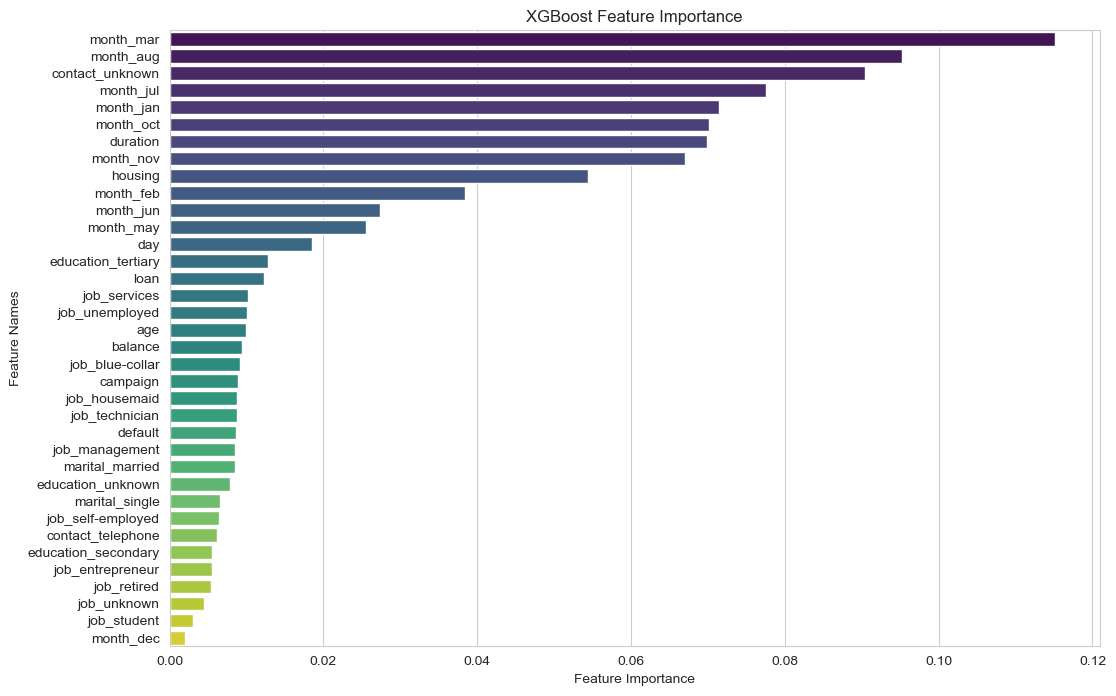

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `model` is a trained XGBoost model
feature_importances = model.feature_importances_
feature_names = X_train.columns  # Replace with your feature names

# Sort features by importance in descending order
sorted_idx = feature_importances.argsort()[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_idx]
sorted_feature_importances = feature_importances[sorted_idx]

# Create a horizontal bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x=sorted_feature_importances, y=sorted_feature_names, palette='viridis')

# Add labels and title
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.title('XGBoost Feature Importance')

# Show the plot
plt.show()

In [62]:
# Define the list of numerical and categorical features based on your dataset
numerical_features = ['age', 'balance', 'day', 'duration', 'campaign']
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'y']

# T-test for numerical features
print("T-test Results for Numerical Features:\n")
for feature in numerical_features:
    subscribed = data[data['y'] == 'yes'][feature]
    not_subscribed = data[data['y'] == 'no'][feature]
    t_stat, p_val = ttest_ind(subscribed, not_subscribed)
    print(f"{feature}: p-value = {p_val:.4f}")

# Chi-square test for categorical features
print("\nChi-square Test Results for Categorical Features:\n")
for feature in categorical_features:
    crosstab = pd.crosstab(data[feature], data['y'])
    chi2, p_val, dof, expected = chi2_contingency(crosstab)
    print(f"{feature}: p-value = {p_val:.4f}")

T-test Results for Numerical Features:

age: p-value = 0.0001
balance: p-value = 0.0000
day: p-value = 0.1992
duration: p-value = 0.0000
campaign: p-value = 0.0000

Chi-square Test Results for Categorical Features:

job: p-value = 0.0000
marital: p-value = 0.0000
education: p-value = 0.0000
default: p-value = 0.2137
housing: p-value = 0.0000
loan: p-value = 0.0000
contact: p-value = 0.0000
month: p-value = 0.0000
y: p-value = 0.0000


In [63]:
# T-test for numerical features
numerical_features = ['age', 'balance', 'day', 'duration', 'campaign']
print("T-test Results for Numerical Features:\n")
for feature in numerical_features:
    subscribed = data[data['y'] == 'yes'][feature]
    not_subscribed = data[data['y'] == 'no'][feature]
    t_stat, p_val = ttest_ind(subscribed, not_subscribed)
    print(f"{feature}: p-value = {p_val:.4f}  (significant)" if p_val < 0.05 else f"{feature}: p-value = {p_val:.4f}")

# Chi-square test for categorical features
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month']
print("\nChi-square Test Results for Categorical Features:\n")
for feature in categorical_features:
    crosstab = pd.crosstab(data[feature], data['y'])
    chi2, p_val, dof, expected = chi2_contingency(crosstab)
    print(f"{feature}: p-value = {p_val:.4f}  (significant)" if p_val < 0.05 else f"{feature}: p-value = {p_val:.4f}")

T-test Results for Numerical Features:

age: p-value = 0.0001  (significant)
balance: p-value = 0.0000  (significant)
day: p-value = 0.1992
duration: p-value = 0.0000  (significant)
campaign: p-value = 0.0000  (significant)

Chi-square Test Results for Categorical Features:

job: p-value = 0.0000  (significant)
marital: p-value = 0.0000  (significant)
education: p-value = 0.0000  (significant)
default: p-value = 0.2137
housing: p-value = 0.0000  (significant)
loan: p-value = 0.0000  (significant)
contact: p-value = 0.0000  (significant)
month: p-value = 0.0000  (significant)


C:\Users\aldhu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\aldhu\AppData\Local\Temp\ipykernel_11032\3354673395.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_summary = data.groupby(['cluster']).mean()


               age      balance        day    duration   campaign
cluster                                                          
0        40.686747  1142.646988  21.792771  156.625904  14.762651
1        40.659021  1006.570676   8.789303  296.146354   2.237201
2        40.422558  1542.754220  22.473760  223.446701   2.493299


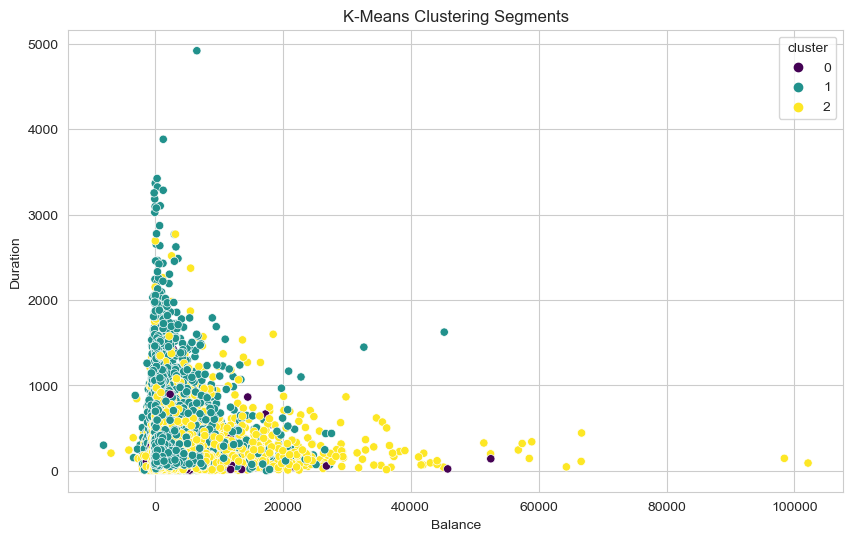

In [68]:
# Scaling the data for clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[numerical_features])

# Applying K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

data['cluster'] = clusters

# Analyze the segments
cluster_summary = data.groupby(['cluster']).mean()
print(cluster_summary)

# Visualize the segments
plt.figure(figsize=(10, 6))
sns.scatterplot(x='balance', y='duration', hue='cluster', data=data, palette='viridis')
plt.title('K-Means Clustering Segments')
plt.xlabel('Balance')
plt.ylabel('Duration')
plt.show()